In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, auc, matthews_corrcoef, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from joblib import load

In [2]:
train_df = pd.read_csv('../Data/2021-train.csv')

train_df.head()

,date,level,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,...,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,x55,y55,z55,pitch_type,pitch_call,pitch_id
0,2019-04-30,MLB,5081ca93,Right,5bf361ca,Right,402559d3,4ff102e5,65ac286a,1,...,-0.543338,88.975403,-4.33686,-1.51515,-2.10376,55,5.84545,FA,InPlay,a89b9e68
1,2019-04-15,MLB,0bf5d3c5,Left,7c67a595,Left,d0d69f32,51a1c7ee,5e710b9e,7,...,1.007350,81.046799,-6.67492,4.81739,3.44978,55,5.62918,FA,BallCalled,eaad389f
2,2019-05-26,MLB,0bf5d3c5,Left,de9d396f,Left,0c59f5af,3007964d,44924919,9,...,0.225512,80.809196,-6.34958,4.08914,3.80582,55,5.50533,FA,InPlay,c8159d29
3,2019-05-27,MLB,af735dc4,Left,073c2b16,Right,a3f610ed,af66b76d,b05114c7,7,...,-0.699844,75.435699,-6.59651,1.92897,2.49333,55,5.94996,SL,StrikeSwinging,e5cde642
4,2019-05-11,MLB,07d9667f,Right,4f03de7c,Right,402559d3,9d34b92a,016c0582,1,...,-0.848172,86.338600,-5.34015,-3.33303,-2.53086,55,6.57091,FA,StrikeSwinging,7c9410bd


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097726 entries, 0 to 1097725
Data columns (total 37 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   date                 1097726 non-null  object 
 1   level                1097726 non-null  object 
 2   pitcher_id           1097726 non-null  object 
 3   pitcher_side         1097726 non-null  object 
 4   batter_id            1097726 non-null  object 
 5   batter_side          1097726 non-null  object 
 6   stadium_id           1097726 non-null  object 
 7   umpire_id            1097726 non-null  object 
 8   catcher_id           1097726 non-null  object 
 9   inning               1097726 non-null  int64  
 10  top_bottom           1097726 non-null  int64  
 11  outs                 1097594 non-null  float64
 12  balls                1097726 non-null  int64  
 13  strikes              1097726 non-null  int64  
 14  release_speed        1097726 non-null  float64
 15

# Data Cleaning

First let's get rid of the null values floating around in the data set. There are a total of 1,097,726 entries in the initial data set, most columns are full but some columns have null values in them. Let's first take a look at the null values in the data set and see if we can fill those.

In [4]:
train_df.isnull().sum()

date                       0
level                      0
pitcher_id                 0
pitcher_side               0
batter_id                  0
batter_side                0
stadium_id                 0
umpire_id                  0
catcher_id                 0
inning                     0
top_bottom                 0
outs                     132
balls                      0
strikes                    0
release_speed              0
vert_release_angle         0
horz_release_angle         0
spin_rate              17878
spin_axis                  0
tilt                     664
rel_height                 0
rel_side                   0
extension                  0
vert_break                 0
induced_vert_break         0
horz_break                 0
plate_height             528
plate_side               528
zone_speed                 0
vert_approach_angle        0
horz_approach_angle        0
x55                        0
y55                        0
z55                        0
pitch_type    

Starting with outs, there are only 132 data points with no "outs" data, since we have no way of knowing how many outs there were on a given pitch, we can safely drop these data points.

In [5]:
train_df = train_df.drop(train_df[train_df['outs'].isnull()].index)

Now let's take a look at spin rate. There are over 17,000 data points missing in this column, so dropping all the values may not be the best idea. Let's take a look at their distribution and see if we can get an idea of how the column looks.

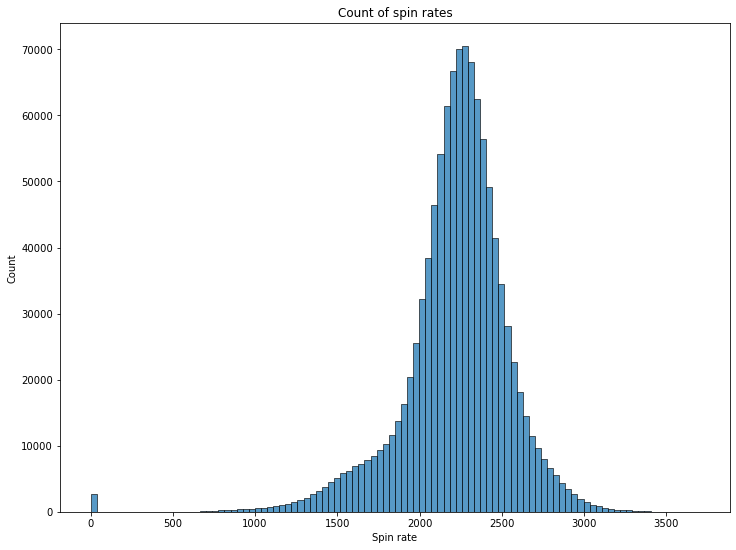

In [6]:
plt.figure(figsize=(12,9))
sns.histplot(train_df[train_df['spin_rate'].notnull()]['spin_rate'], bins=100, kde=False)
plt.xlabel('Spin rate')
plt.ylabel('Count')
plt.title('Count of spin rates')
plt.show()

It looks like a normal shaped curve, which is expected from this type of data. Filling the missing values with the average would be the best way to go. That keeps the normal distribution of this variable intact and shouldn't have any adverse effect on any future modeling.

In [7]:
train_df['spin_rate'].describe()

count    1.079719e+06
mean     2.219898e+03
std      3.255185e+02
min      0.000000e+00
25%      2.083710e+03
50%      2.248990e+03
75%      2.403110e+03
max      3.698960e+03
Name: spin_rate, dtype: float64

In [8]:
train_df['spin_rate'].fillna(train_df['spin_rate'].mean(), inplace=True)

Tilt is the next column to have missing values, but we'll take a look at that in the next part of the notebook, for now we'll move on to plate height and plate side.

Next up is plate_height and plate_side, with equal numbers of missing values, I would guess that all of the missing values have both columns missing, let's take a look.

In [9]:
train_df[train_df['plate_height'].isnull()][['plate_height', 'plate_side']]

,plate_height,plate_side
592,NaN,NaN
885,NaN,NaN
1024,NaN,NaN
1348,NaN,NaN
2645,NaN,NaN
...,...,...
1081321,NaN,NaN
1083016,NaN,NaN
1083024,NaN,NaN
1083177,NaN,NaN


Indeed that was the case. With only 528 rows of missing data, these can be filled with their mean values without adding much bias to our data set.

In [10]:
train_df['plate_height'].fillna(train_df['plate_height'].mean(), inplace=True)
train_df['plate_side'].fillna(train_df['plate_side'].mean(), inplace=True)

Finally, we have the pitch_type column. Let's take a look at that data and see if we can fill some missing values.

In [11]:
train_df[train_df['pitch_type'].isnull()]

,date,level,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,...,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,x55,y55,z55,pitch_type,pitch_call,pitch_id
3683,2019-06-12,AAA,5da5270c,Right,7d0c379b,Right,cbf018ad,9c6cbb5e,9c6cbb5e,2,...,-1.285140,70.803398,-11.19630,-3.593610,-1.33605,55,6.17661,NaN,BallCalled,05cdd3d7
4297,2019-05-19,AA,3ae48ff0,Right,ffc05a5e,Left,605d1de7,9c6cbb5e,9c6cbb5e,7,...,1.380540,88.023903,-5.66636,-0.041822,-2.18288,55,6.54158,NaN,BallIntentional,7b0d1e9b
4318,2019-05-19,AA,3ae48ff0,Right,ffc05a5e,Left,605d1de7,9c6cbb5e,9c6cbb5e,7,...,1.967930,87.042397,-4.46674,0.826258,-2.11492,55,6.46151,NaN,BallIntentional,ccc6eb1b
4798,2019-06-12,AAA,5da5270c,Right,4b2e359b,Left,cbf018ad,9c6cbb5e,9c6cbb5e,1,...,-0.555812,67.851196,-11.25750,-3.008580,-1.32933,55,6.21673,NaN,StrikeSwinging,4deaa210
6292,2019-05-19,AA,3ae48ff0,Right,ffc05a5e,Left,605d1de7,9c6cbb5e,9c6cbb5e,7,...,1.439470,87.917503,-5.95837,0.206907,-2.06420,55,6.59596,NaN,BallIntentional,03b03578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081813,2019-06-13,AA,92a2eea2,Right,7d715c5f,Left,425ed55c,9c6cbb5e,9c6cbb5e,7,...,0.810245,75.976501,-5.78642,4.860220,3.25380,55,5.52707,NaN,BallCalled,80f87ff5
1082065,2019-06-13,AA,92a2eea2,Right,400b817f,Left,425ed55c,9c6cbb5e,9c6cbb5e,7,...,0.429119,73.011101,-7.26793,5.164310,3.36949,55,5.34727,NaN,StrikeCalled,1c9996d4
1082825,2019-04-22,MLB,225e22e5,Left,1023df14,Left,fe6b0f40,9c6cbb5e,9c6cbb5e,8,...,1.000600,88.074600,-4.13948,-0.666996,-2.16794,55,6.08221,NaN,BallCalled,f4afe64b
1092799,2019-05-03,MLB,b5aab6d9,Right,d020b81d,Left,a69810e0,0b7f4ad5,f0a5d54a,6,...,1.897010,81.827202,-4.40944,1.381950,-1.29461,55,5.49077,NaN,BallCalled,c27e6e9d


With only 556 rows missing, I feel comfortable dropping these instances. Plus, we have no way of knowing for sure what pitch was thrown. We could gather educated guesses based on speed, and vertical and horizontal approach angle, but even then it's tough to tell between sliders and curveballs or fastballs and changeups. Better to drop the rows to keep our data accurate than take guesses on what pitches were thrown.

In [12]:
train_df = train_df.drop(train_df[train_df['pitch_type'].isnull()].index)

In [13]:
train_df = train_df.reset_index().drop('index', axis=1)

train_df.isnull().sum()

date                     0
level                    0
pitcher_id               0
pitcher_side             0
batter_id                0
batter_side              0
stadium_id               0
umpire_id                0
catcher_id               0
inning                   0
top_bottom               0
outs                     0
balls                    0
strikes                  0
release_speed            0
vert_release_angle       0
horz_release_angle       0
spin_rate                0
spin_axis                0
tilt                   663
rel_height               0
rel_side                 0
extension                0
vert_break               0
induced_vert_break       0
horz_break               0
plate_height             0
plate_side               0
zone_speed               0
vert_approach_angle      0
horz_approach_angle      0
x55                      0
y55                      0
z55                      0
pitch_type               0
pitch_call               0
pitch_id                 0
d

In [14]:
train_df.head()

,date,level,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,...,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,x55,y55,z55,pitch_type,pitch_call,pitch_id
0,2019-04-30,MLB,5081ca93,Right,5bf361ca,Right,402559d3,4ff102e5,65ac286a,1,...,-0.543338,88.975403,-4.33686,-1.51515,-2.10376,55,5.84545,FA,InPlay,a89b9e68
1,2019-04-15,MLB,0bf5d3c5,Left,7c67a595,Left,d0d69f32,51a1c7ee,5e710b9e,7,...,1.007350,81.046799,-6.67492,4.81739,3.44978,55,5.62918,FA,BallCalled,eaad389f
2,2019-05-26,MLB,0bf5d3c5,Left,de9d396f,Left,0c59f5af,3007964d,44924919,9,...,0.225512,80.809196,-6.34958,4.08914,3.80582,55,5.50533,FA,InPlay,c8159d29
3,2019-05-27,MLB,af735dc4,Left,073c2b16,Right,a3f610ed,af66b76d,b05114c7,7,...,-0.699844,75.435699,-6.59651,1.92897,2.49333,55,5.94996,SL,StrikeSwinging,e5cde642
4,2019-05-11,MLB,07d9667f,Right,4f03de7c,Right,402559d3,9d34b92a,016c0582,1,...,-0.848172,86.338600,-5.34015,-3.33303,-2.53086,55,6.57091,FA,StrikeSwinging,7c9410bd


There we go, we have a mostly clean dataset that is nearly ready to go for our machine learning model. But first, let's create our target variable.

# Data Wrangling

In the test set, the target variable is called "is_swing", and we don't have a column like that here in the training set. However, we do have a "pitch_call" column, which we can use to create the "is_swing" column. Swinging strikes, any ball batted in to play, or any foul balls are swings at the pitch, so using this, we can build the "is_swing" column using a simple lambda function.

In [15]:
train_df['pitch_call'].unique()

array(['InPlay', 'BallCalled', 'StrikeSwinging', 'FoulBall',
       'StrikeCalled', 'HitByPitch'], dtype=object)

In [16]:
is_swing_list = ['InPlay', 'StrikeSwinging', 'FoulBall']
train_df['is_swing'] = train_df['pitch_call'].apply(lambda x: 1 if x in is_swing_list else 0)

Now we have our data set with the target variable, let's take a look at the "is_swing" column and its value counts.

In [17]:
train_df['is_swing'].value_counts()

0    585194
1    511844
Name: is_swing, dtype: int64

A pretty balanced classification problem. About 70,000 more instances of the 0 class than the 1 class, but that's not too much cause for concern. If we have any overfitting in our training data, we may have to do some resampling, but that seems unlikely.

Before we get into modeling however, there was something I noticed something strange with the "tilt" column. It has two different types of string data packed into the column. We'll need to fix that column to get it all into one data format.

In [18]:
train_df['tilt'].unique()

array(['1:15', '11:15', '11:00', '12:30', '8:15', '9:45', '11:30', '2:15',
       '5:45', '12:45', '2:30', '1:30', '3:00', '4:45', '3:30', '10:45',
       '10:00', '10:15', '1:00', '10:30', '1:45', '12:00', '2:00', '8:00',
       '7:00', '4:00', '11:45', '7:15', '5:00', '6:45', '8:45', '3:15',
       '5:15', '8:30', '7:45', '12:15', '7:30', '9:15', '9:30', '5:30',
       '2:45', '6:30', '4:15', '9:00', '6:15', '3:45', '4:30',
       '03:30:00.0000000', '6:00', '10:30:00.0000000', nan,
       '05:30:00.0000000', '02:45:00.0000000', '08:30:00.0000000',
       '07:15:00.0000000', '10:45:00.0000000', '01:30:00.0000000',
       '11:00:00.0000000', '05:45:00.0000000', '01:00:00.0000000',
       '02:15:00.0000000', '04:15:00.0000000', '07:00:00.0000000',
       '12:30:00.0000000', '09:45:00.0000000', '01:45:00.0000000',
       '11:15:00.0000000', '08:15:00.0000000', '10:00:00.0000000',
       '12:15:00.0000000', '04:00:00.0000000', '12:45:00.0000000',
       '09:30:00.0000000', '02:00:00.0000

I'm choosing to turn all of the "03:30:00.0000000", "07:15:00.0000000" into the "3:30", "7:15" format, then turn that into a seconds-from-midnight integer. This will give the model a number to look at, instead of a time-series or string object. This will be simpler for the model to analyze and could lead to better results.

In [19]:
train_df['tilt'] = train_df['tilt'].apply(lambda x: x[0:5] if pd.notnull(x) and len(x) > 5 else x)
train_df['tilt'].unique()

array(['1:15', '11:15', '11:00', '12:30', '8:15', '9:45', '11:30', '2:15',
       '5:45', '12:45', '2:30', '1:30', '3:00', '4:45', '3:30', '10:45',
       '10:00', '10:15', '1:00', '10:30', '1:45', '12:00', '2:00', '8:00',
       '7:00', '4:00', '11:45', '7:15', '5:00', '6:45', '8:45', '3:15',
       '5:15', '8:30', '7:45', '12:15', '7:30', '9:15', '9:30', '5:30',
       '2:45', '6:30', '4:15', '9:00', '6:15', '3:45', '4:30', '03:30',
       '6:00', nan, '05:30', '02:45', '08:30', '07:15', '01:30', '05:45',
       '01:00', '02:15', '04:15', '07:00', '09:45', '01:45', '08:15',
       '04:00', '09:30', '02:00', '01:15', '07:30', '05:15', '04:30',
       '09:00', '08:00', '07:45', '09:15', '08:45', '03:00', '03:15',
       '02:30', '06:00', '03:45', '05:00', '06:45', '06:15', '06:30',
       '04:45'], dtype=object)

In [20]:
train_df['tilt'] = train_df['tilt'].map(lambda x: sum(a*int(t) for a, t in zip([3600, 60], x.split(':'))) if pd.notnull(x) and ':' in x \
                                        else (int(x[:-5]) if pd.notnull(x) else x))

train_df['tilt'].unique()

array([ 4500., 40500., 39600., 45000., 29700., 35100., 41400.,  8100.,
       20700., 45900.,  9000.,  5400., 10800., 17100., 12600., 38700.,
       36000., 36900.,  3600., 37800.,  6300., 43200.,  7200., 28800.,
       25200., 14400., 42300., 26100., 18000., 24300., 31500., 11700.,
       18900., 30600., 27900., 44100., 27000., 33300., 34200., 19800.,
        9900., 23400., 15300., 32400., 22500., 13500., 16200., 21600.,
          nan])

We got tilt figured out, we can now impute the missing values in this column to get a clean data set.

In [21]:
train_df['tilt'].fillna(train_df['tilt'].median(), inplace=True)

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097038 entries, 0 to 1097037
Data columns (total 38 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   date                 1097038 non-null  object 
 1   level                1097038 non-null  object 
 2   pitcher_id           1097038 non-null  object 
 3   pitcher_side         1097038 non-null  object 
 4   batter_id            1097038 non-null  object 
 5   batter_side          1097038 non-null  object 
 6   stadium_id           1097038 non-null  object 
 7   umpire_id            1097038 non-null  object 
 8   catcher_id           1097038 non-null  object 
 9   inning               1097038 non-null  int64  
 10  top_bottom           1097038 non-null  int64  
 11  outs                 1097038 non-null  float64
 12  balls                1097038 non-null  int64  
 13  strikes              1097038 non-null  int64  
 14  release_speed        1097038 non-null  float64
 15

In [23]:
train_df.to_csv('../Data/model_data.csv')

# Predictive Modeling

Now that our data set clean and how we want it, we can get into some predictive modeling. Seeing as this is a binary classification problem, we'll need to use a classification algorithm. I'm choosing to use gradient boosting here because I've used it in the past and have gotten good results with it in a timely manner. Logistic regression would be faster, but would give us a less accurate model than a gradient boosting model. Getting dummy variables for some of the categorical variables would be good for modeling. It will allow us to see how much importance was placed on these features by the model.

I'm going to do the hyperparameter tuning in its own dedicated notebook, then load the trained model into this notebook after it's been fitted with all the correct hyperparameters.

In [24]:
X = train_df.drop(['pitcher_id', 'batter_id', 'stadium_id', 'umpire_id', 'catcher_id', 'pitch_call', 'is_swing', 'pitch_id', 'date'], axis=1)
y = train_df['is_swing']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=11, test_size=.15)

X_train = pd.get_dummies(X_train, prefix=['level', 'pitcher', 'batter', 'is'], columns=['level', 'pitcher_side', 'batter_side', 'pitch_type'], dtype='int64')
X_valid = pd.get_dummies(X_valid, prefix=['level', 'pitcher', 'batter', 'is'], columns=['level', 'pitcher_side', 'batter_side', 'pitch_type'], dtype='int64')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932482 entries, 24948 to 541457
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   inning               932482 non-null  int64  
 1   top_bottom           932482 non-null  int64  
 2   outs                 932482 non-null  float64
 3   balls                932482 non-null  int64  
 4   strikes              932482 non-null  int64  
 5   release_speed        932482 non-null  float64
 6   vert_release_angle   932482 non-null  float64
 7   horz_release_angle   932482 non-null  float64
 8   spin_rate            932482 non-null  float64
 9   spin_axis            932482 non-null  float64
 10  tilt                 932482 non-null  float64
 11  rel_height           932482 non-null  float64
 12  rel_side             932482 non-null  float64
 13  extension            932482 non-null  float64
 14  vert_break           932482 non-null  float64
 15  induced_vert_

Now that we have our modeling dataset, let's get into modeling the data. Take a look at a few base machine learning models. I chose LogisticRegression, RandomForestClassifier, KNeighborsClassifier, and finally a Gradient Boosting Classifier. Whichever model comes out on top, we'll take that and do some hyperparameter tuning in the "Mariners Machine Learning Model" notebook to make the machine learning algorithm even better.

Starting with the simple Logistic Regression model:

In [25]:
logreg = LogisticRegression(random_state=34, max_iter=10000)
logreg.fit(X_train, y_train)
print(logreg.score(X_train, y_train))
print(logreg.score(X_valid, y_valid))

0.5801216538228083
0.5799910061012664


Not a good model at all. No signs of overfitting which is good, but only 50% accuracy is not good at all. Let's move on to a model that's usually pretty good, Random Forest.

In [26]:
rnd_clf = RandomForestClassifier(random_state=34)
rnd_clf.fit(X_train, y_train)
print(rnd_clf.score(X_train, y_train))
print(rnd_clf.score(X_valid, y_valid))

0.9999978551864808
0.7768662339872141


Lots of overfitting here. The model does a really good job on the training data, but not nearly as well on data it's never seen before. Let's next take a look at a K-Nearest Neighbors Classifier.

In [27]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
print(knn_clf.score(X_train, y_train))
print(knn_clf.score(X_valid, y_valid))

0.716581124354143
0.5425994798123435


Not the best. Some overfitting here for sure. Unfortunately the validation score isn't very good at all, let's move on to the XGBoost Classifier to see if we get better results.

In [28]:
xgb = XGBClassifier(seed=34)
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
print(xgb.score(X_valid, y_valid))

0.7705789495132346
0.7675806412406718


Pretty similar to the Random Forest validation score, but without the overfitting. Looks like we'll use the Extreme Gradient Boosting model as our machine learning algorithm of choice to do some hyperparameter tuning.

First we'll make predictions on our validation set to get some metrics on how the base model performs.

Base XGB Classifier Test Accuracy: 76.76
Base XGB Classifier Classification Report
              precision    recall  f1-score   support

           0       0.79      0.76      0.78     87779
           1       0.74      0.77      0.76     76777

    accuracy                           0.77    164556
   macro avg       0.77      0.77      0.77    164556
weighted avg       0.77      0.77      0.77    164556



Base XGB Classifier MCC Score: 0.5347105189212402


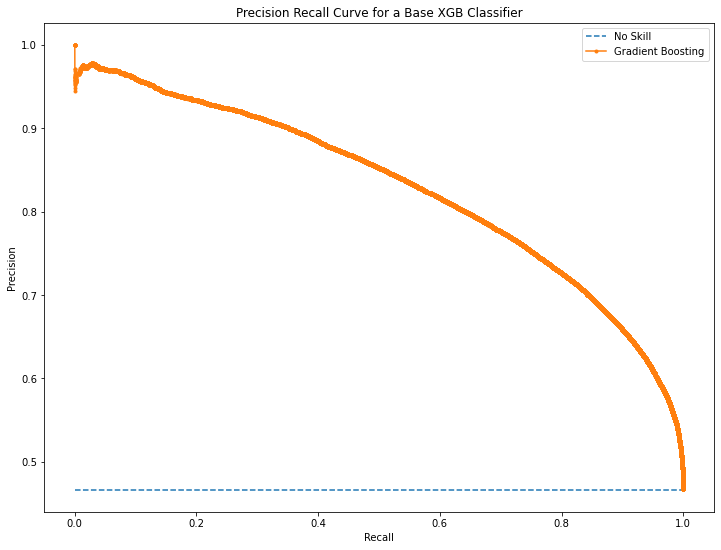

Base XGB Classifier AUC Score: 0.8284510547471416


In [29]:
xgb_base_pred = xgb.predict(X_valid)

print(f'Base XGB Classifier Test Accuracy: {round(accuracy_score(y_valid, xgb_base_pred) * 100, 2)}')
print('Base XGB Classifier Classification Report')
print(classification_report(y_valid, xgb_base_pred))
print('\n')
print(f'Base XGB Classifier MCC Score: {matthews_corrcoef(y_valid, xgb_base_pred)}')

xgb_probs = xgb.predict_proba(X_valid)
xgb_probs = xgb_probs[:, 1]

xgb_precision, xgb_recall, _ = precision_recall_curve(y_valid, xgb_probs)

no_skill = len(y_valid[y_valid == 1]) / len(y_valid)
plt.figure(figsize=(12,9))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='Gradient Boosting')
plt.title('Precision Recall Curve for a Base XGB Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

print(f'Base XGB Classifier AUC Score: {auc(xgb_recall, xgb_precision)}')

By itself, it's a good model. 77% accuracy and a solid precision/recall on both classes is a good start. As well as a .537 MCC score and very high AUC score. Looks like the base XGBoost is a good starting out point for the hyperparameter tuning we did in the other notebook. Let's load that in and take a look at the same metrics as above.

Tuned XGB Classifier Test Accuracy: 78.96
Tuned XGB Classifier Classification Report
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     87779
           1       0.77      0.79      0.78     76777

    accuracy                           0.79    164556
   macro avg       0.79      0.79      0.79    164556
weighted avg       0.79      0.79      0.79    164556



Tuned XGB Classifier MCC Score: 0.5782494588877023


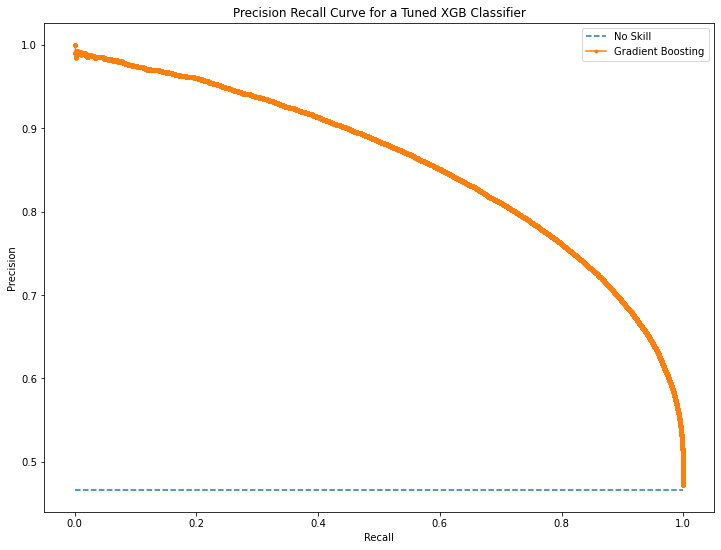

Tuned XGB Classifier AUC Score: 0.8568927887315549


In [30]:
tuned_xgb = load('tuned_xgboost_model.pkl')
xgb_tuned_pred = tuned_xgb.predict(X_valid)

print(f'Tuned XGB Classifier Test Accuracy: {round(accuracy_score(y_valid, xgb_tuned_pred) * 100, 2)}')
print('Tuned XGB Classifier Classification Report')
print(classification_report(y_valid, xgb_tuned_pred))
print('\n')
print(f'Tuned XGB Classifier MCC Score: {matthews_corrcoef(y_valid, xgb_tuned_pred)}')

xgb_probs = tuned_xgb.predict_proba(X_valid)
xgb_probs = xgb_probs[:, 1]

xgb_precision, xgb_recall, _ = precision_recall_curve(y_valid, xgb_probs)

no_skill = len(y_valid[y_valid == 1]) / len(y_valid)
plt.figure(figsize=(12,9))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='Gradient Boosting')
plt.title('Precision Recall Curve for a Tuned XGB Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

print(f'Tuned XGB Classifier AUC Score: {auc(xgb_recall, xgb_precision)}')

Definitely did better. We see a 2.2 point increase in accuracy, and all the other metrics we're looking at have gone up as well. MCC score has risen as well as the AUC score, which are both signs that we have a better tuned model. While they haven't risen a lot, the hyperparameter tuning we did in the other notebook has had a noticeable effect on our prediction power.

Something that would be interesting to look at is the feature importances of our model. This tells us how important each variable in making the predictions on the "is_swing" column.

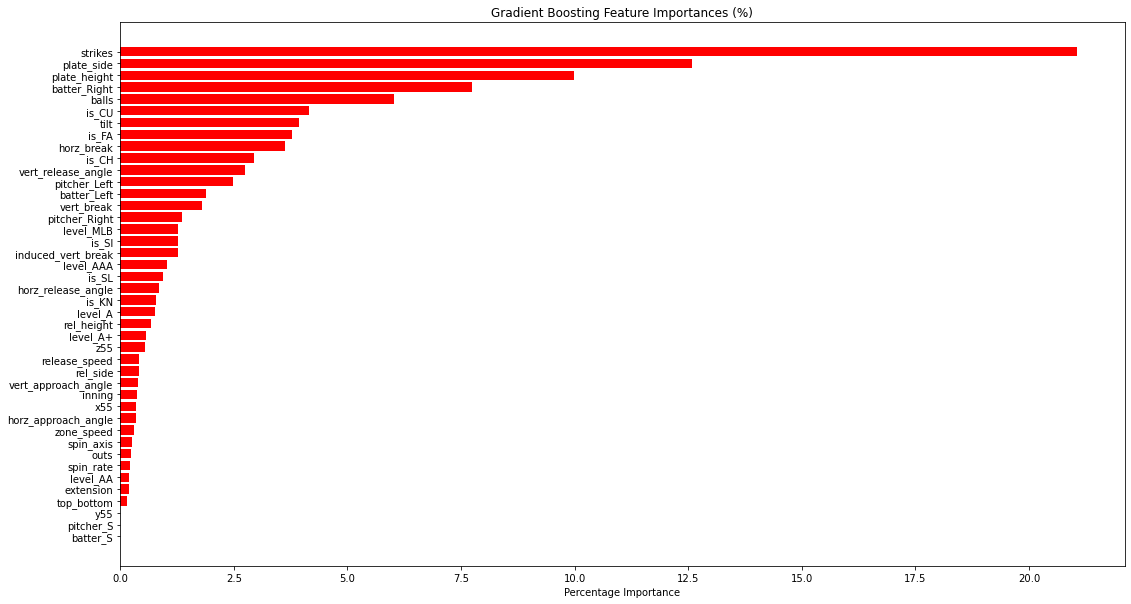

In [31]:
feature_importances = pd.DataFrame(pd.Series(tuned_xgb.feature_importances_), columns=['Importance'])
feature_importances.index = X_train.columns
feature_importances = feature_importances.sort_values('Importance')

plt.figure(figsize=(18,10))
plt.barh(feature_importances.index, width=feature_importances['Importance'] * 100, color='r')
plt.title("Gradient Boosting Feature Importances (%)")
plt.xlabel('Percentage Importance')
plt.show()

Very interesting. Apparently the strike count is the most important feature, with where the ball is located, both plate height and side, coming right behind it. Strikes being the most important feature isn't surprising. Batters are more likely to swing with 2 strikes, while being a little bit more picky about the pitches they swing at with no strikes or 1 strike in the count. With 2 strikes, they feel like they need to protect the plate and keep the at-bat alive so they have another chance of putting the ball in play and getting a hit.

## Making predictions on test set

We have a good model trained, now we can make predictions on the testing set. First we need to load it in and clean it the way we cleaned the training set.

In [32]:
test_df = pd.read_csv('../Data/2021-test.csv')

test_df.isnull().sum()

date                        0
level                       0
pitcher_id                  0
pitcher_side                0
batter_id                   0
batter_side                 0
stadium_id                  0
umpire_id                   0
catcher_id                  0
inning                      0
top_bottom                  0
outs                        0
balls                       0
strikes                     0
release_speed               0
vert_release_angle          0
horz_release_angle          0
spin_rate                6397
spin_axis                   0
tilt                      195
rel_height                  0
rel_side                    0
extension                   0
vert_break                  0
induced_vert_break          0
horz_break                  0
plate_height               51
plate_side                 51
zone_speed                  0
vert_approach_angle         0
horz_approach_angle         0
x55                         0
y55                         0
z55       

In [33]:
def clean_and_wrangle(df):
    
    df['spin_rate'] = df['spin_rate'].fillna(df['spin_rate'].mean())
    df = df.drop(df[df['pitch_type'].isnull()].index)
    df['plate_height'] = df['plate_height'].fillna(df['plate_height'].mean())
    df['plate_side'] = df['plate_side'].fillna(df['plate_side'].mean())
    df = df.reset_index().drop('index', axis=1)
    
    df['tilt'] = df['tilt'].map(lambda x: sum(a*int(t) for a, t in zip([3600, 60], x.split(':'))) if pd.notnull(x) and ':' in x \
                                        else (int(x[:-5]) if pd.notnull(x) else x))
    
    df['tilt'] = df['tilt'].fillna(df['tilt'].median())

    return df

In [34]:
test_df = clean_and_wrangle(test_df)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370092 entries, 0 to 370091
Data columns (total 37 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   date                 370092 non-null  object 
 1   level                370092 non-null  object 
 2   pitcher_id           370092 non-null  object 
 3   pitcher_side         370092 non-null  object 
 4   batter_id            370092 non-null  object 
 5   batter_side          370092 non-null  object 
 6   stadium_id           370092 non-null  object 
 7   umpire_id            370092 non-null  object 
 8   catcher_id           370092 non-null  object 
 9   inning               370092 non-null  int64  
 10  top_bottom           370092 non-null  int64  
 11  outs                 370092 non-null  int64  
 12  balls                370092 non-null  int64  
 13  strikes              370092 non-null  int64  
 14  release_speed        370092 non-null  float64
 15  vert_release_angl

No null values (except our target variable "is_strike"). We'll use our trained model from up above and make predictions on the entire testing set and insert those predictions into the data set.

In [35]:
X = test_df.drop(['pitcher_id', 'batter_id', 'stadium_id', 'umpire_id', 'catcher_id', 'is_swing', 'pitch_id', 'date'], axis=1)

X = pd.get_dummies(X, prefix=['level', 'pitcher', 'batter', 'is'], columns=['level', 'pitcher_side', 'batter_side', 'pitch_type'], dtype='int64')

In [36]:
predictions = tuned_xgb.predict(X)

test_df['is_swing'] = predictions
test_df.head(10)

,date,level,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,...,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,x55,y55,z55,pitch_type,pitch_id,is_swing
0,2019-07-18,MLB,73a10ae1,Right,193282c0,Left,c9712626,5f8ae81c,a421b54b,8,...,-0.838435,86.057800,-5.08777,-1.114830,-0.643664,55,6.01219,FA,3881a47c,1
1,2019-07-13,AAA,6bd3ec6f,Left,5698002d,Right,46a1046e,9c6cbb5e,9c6cbb5e,6,...,1.563680,73.719101,-8.59511,6.265450,3.538150,55,6.24963,CU,39dd6dfc,0
2,2019-07-17,A+,600b75dd,Right,ef1e4ac0,Left,1e3c100c,9c6cbb5e,9c6cbb5e,10,...,2.005520,73.999100,-6.51041,-0.175223,-1.783860,55,5.91202,CU,663d1bbe,0
3,2019-07-19,AAA,35acb148,Left,357d82e5,Right,66b03ca6,9c6cbb5e,9c6cbb5e,4,...,-0.185987,80.165703,-5.57020,-0.343069,0.951319,55,6.03310,FA,f91e27cd,1
4,2019-07-03,MLB,ae87a7a4,Right,f7e769f3,Right,a69810e0,77f5f822,8ebd2bf2,5,...,-0.590431,82.306000,-7.51385,-0.385693,-1.368450,55,6.11413,SI,58497823,0
5,2019-07-06,AA,dd4fb716,Right,99f2b51d,Right,84e57cf4,9c6cbb5e,9c6cbb5e,3,...,0.077814,79.887398,-7.57216,-1.500930,-1.373100,55,6.38914,SL,7d446654,1
6,2019-07-20,MLB,9600898b,Left,7028bc34,Right,7cfd1ecb,667d5752,e9553a98,6,...,-0.911064,85.352600,-6.17392,0.445947,2.669410,55,5.92422,SI,bac2af8a,0
7,2019-07-06,AA,6e5500fa,Left,8ab0e5f3,Left,84e57cf4,9c6cbb5e,9c6cbb5e,1,...,0.465729,73.465103,-6.44025,1.760880,0.985060,55,5.59830,SL,ec3747e5,0
8,2019-07-16,A,e481e50d,Right,2ffc4fe3,Left,9cd73a6f,9c6cbb5e,9c6cbb5e,9,...,1.202160,84.919800,-4.06971,0.895900,-1.224260,55,5.28796,FA,b13c7a11,0
9,2019-07-16,A,3f0bfa01,Right,bb34853c,Right,9cd73a6f,9c6cbb5e,9c6cbb5e,6,...,-0.949888,76.070801,-8.73282,-2.627950,-0.976320,55,5.97025,SL,8ac06bf0,1


In [37]:
test_df[['pitch_id','is_swing']].to_csv('../Data/predicted_test_set.csv')

# Conclusion

Overall we created a good model to predict whether a batter is going to swing at a certain pitch or not. We started off by cleaning the data set and making sure that no null values were in the table. Next we had to create the target variable from a column that already existed in the data set. Finally had to wrangle some data to get it all in the correct format to be suitable to run a machine learning model on. Using gradient boosting, tuned a number of hyperparameters, and made predictions on the full training set. After making predictions, we needed to make sure the model was performing well, and took a look at a number of different metrics for model performance. Accuracy, the classification report, AUC score, and Matthew's Correlation Coefficient all agreed that this model we built was well suited for predicting if a hitter was going to swing. We also took a look at some of the feature importances for our model, with number of strikes in the count coming out on top as the most important feature, followed up by plate side and plate height, then numbers of balls in the count.

If I had more time and resources to dedicate to this project, I would have tuned some more of the XGBoost hyperparameters to make this model even more accurate. Having only tuned three parameters, there could be some more room for improvement, but the time it could have taken to do so may have outweighed the gains produce by finding more optimal parameters. I also would have expanded the search of the optimal parameters. One of the hyperparameters was found at the bounds of what I set to search for, so by changing the bounds, I could have found a better hyperparameter for the model. Another thing I would have tried was ensemble learning. Training a few different types of models on this dataset (logistic regression, xgboost, random forest, K-neighbors), then putting those models into a voting classifier could potentially give us a more accurate model to make predictions with. Finally, I would have liked to use a Randomized Grid Search or Bayesian Optimization to find better hyperparameters. This would have given the model a chance to settle on more optimal hyperparameters than the ones I had it search through, giving us a better model overall.